<a href="https://colab.research.google.com/github/Nagasuruthika/DogBreedClassifier/blob/main/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==0.20.3  # Compatibility

     |████████████████████████████████| 10.4MB 4.9MB/s 
  ERROR: Failed building wheel for pandas
  Running setup.py clean for pandas
Failed to build pandas
ERROR: xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.20.3 which is incompatible.
ERROR: seaborn 0.11.1 has requirement pandas>=0.23, but you'll have pandas 0.20.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: pandas-datareader 0.9.0 has requirement pandas>=0.23, but you'll have pandas 0.20.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.20.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 0.20.3 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.20.3 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling panda

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') #mounting google drive to access dataset

Mounted at /content/gdrive


In [ ]:
!unzip -n -qq "/content/gdrive/My Drive/dogbreed.zip"
!ls "/content/dogbreed/"
!unzip -n -qq "/content/dogbreed/dog-breed-identification.zip"
!unzip -n -qq "/content/test.zip"
!unzip -n -qq "/content/train.zip"
!cp "/content/dogbreed/support.py" "./"
!echo "Files unzipped and copied!" #unzipping the zip file data

desktop.ini  dog-breed-identification.zip  support.py
Files unzipped and copied!


We begin by importing the neccessary packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

Selecting 10 breeds of dogs for training the neural  network

In [ ]:

num_classes = 50 
seed = 42 
im_size = 299 
batch_size = 32 
df = pd.read_csv('labels.csv')
selected_breed_list = ['beagle', 'chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
'tibetan_mastiff']
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


In [ ]:
breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

total number of breeds to classify 10


Making dog breed into vectors by character encoding using scikit learn

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder() 
np.random.seed(seed=seed) 
rnd = np.random.random(len(df)) 
train_idx = rnd < 0.9 
valid_idx = rnd >= 0.9

#Encoding and  Also Separating Our Testing and Training Set Randomly.
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx] 
yv = y_train[valid_idx] 

Pre-processing the Image

In [ ]:
from tqdm import tqdm
from keras.applications import xception
from support import read_img

x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, data_dir,'train', (im_size, im_size))
    
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))

    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
       
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))


841it [00:05, 154.64it/s]

Train Images shape: (752, 299, 299, 3) size: 201,688,656


Image Augmentation using keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)

Declaring Neural network model

In [ ]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input

base_model = xception.Xception(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

83689472/83683744 [==============================] - 1s 0us/step


Training the Neural Network 

In [ ]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs = 10
learning_rate = 0.001

early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d")) 
bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)



optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit_generator(train_generator,
                           steps_per_epoch=train_idx.sum() // batch_size,
                           epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                           validation_data=valid_generator,
                           validation_steps=valid_idx.sum() // batch_size)

model.save(bst_model_path)
print("Saved model to disk") 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
23/23 [==============================] - 331s 14s/step - loss: 0.0669 - accuracy: 0.9739 - val_loss: 0.0044 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00439, saving model to 2021-03-15_dog_breed_model.h5
Epoch 2/10
23/23 [==============================] - 307s 13s/step - loss: 0.0534 - accuracy: 0.9854 - val_loss: 0.0108 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 0.00439
Epoch 3/10
23/23 [==============================] - 307s 13s/step - loss: 0.0581 - accuracy: 0.9857 - val_loss: 7.1286e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00439 to 0.00071, saving model to 2021-03-15_dog_breed_model.h5
Epoch 4/10
23/23 [==============================] - 311s 14s/step - loss: 0.0292 - accuracy: 0.9917 - val_loss: 0.0291 - val_accuracy: 0.9844

Epoch 00004: val_loss did not improve from 0.00071
Epoch 5/10
23/23 [==============================] - 313s 14s/step - loss: 0.0534 - accuracy: 0.9875 - val_loss: 1.1480e-04

Image Pre-processing function

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255
 
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
  
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class, max(pred)

Feeding images and making predictions

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving download.jpg to download.jpg


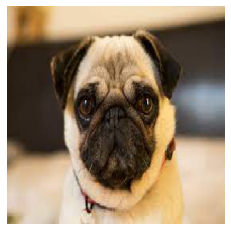

pug
1.0


In [ ]:
img_path = 'download.jpg'                             
classes, prob = predict_from_image(img_path)
print(f"{classes}\n{prob[selected_breed_list.index(classes)]}")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving beagle.jpg to beagle.jpg


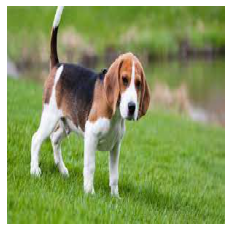

beagle
1.0


In [ ]:
img_path = 'beagle.jpg'                             
classes, prob = predict_from_image(img_path)
print(f"{classes}\n{prob[selected_breed_list.index(classes)]}")